# Correction Factor

In the TOTEM experiment, scattered protons deviate at very small angles. However, due to the physical limitations of the detectors—particularly near the edge closest to the beam—these small-angle protons are not always detected. This issue is especially prominent for events with very small values of $|\theta^*_y|$.

Furthermore, the internal structure of the LHC and its aperture limitations (e.g., magnets and beam pipe geometry) prevent protons with large $|\theta^*_y|$ values from reaching the detectors. For example, the upper bound is approximately $|\theta^*_y| \approx 100\, \mu\text{rad}$.

Because of the limited detector acceptance, the number of observed events does not directly reflect the true physical distribution. Therefore, an **acceptance correction factor** (Equation 1.) is applied at each measurement point. The product of these correction factors allows the experimentally measured distributions to be transformed into more accurate physical distributions.

$$A(\theta^*, \theta^*_y)=A_{geom}(\theta^*) \cdot A_{fluct}(\theta^*_y) \tag{1}$$

This enables reliable determination of the **differential cross-section**.

In this step:
- The geometrical acceptance is computed from detector geometry and beam optics parameters.
- The fluctuation correction is calculated to account for beam divergence (angular smearing). 
- The total acceptance correction is computed.

## Environment Setup

In [1]:
import ROOT 
from pathlib import Path
import numpy as np

ROOT.EnableImplicitMT()

### Setting constants needed for calculating correction

In elastic proton-proton scattering, we measure the vertical scattering angle $\theta_y^*$. However, due to:
* sensor coverage limitations (especially at small $\theta_y^*$ values),
* and LHC aperture restrictions (which limit $\theta_y^*$ from above),

only events within certain angular thresholds are considered valid for physics analysis. To handle this properly, cut thresholds are applied for each detector arm (left and right), which define the minimum and maximum acceptable $\theta_y^*$ values. These thresholds differ for each dataset and diagonal, because:
* Beam conditions (e.g., emittance) may vary across runs.
* Sensor positions may differ slightly.
* Different diagonals involve different detector configurations.

The code below  prepares the necessary constants and dataset selection needed to calculate the acceptance correction factors for the TOTEM experiment.

In [2]:
dataset_number = 3
diagonal_number = 1 # 1 - diagonal 45b56t, 0 - diagonal 45t56b

In [3]:
if not isinstance(dataset_number, int) or not (1 <= dataset_number <= 3):
    raise ValueError("Dataset number must be an integer 1 or 2 or 3")

if not isinstance(diagonal_number, int) or not (0 <= diagonal_number <= 1):
    raise ValueError("Diagonal has to be number 0 or 1")

# CONSTANT DEFINITION

# The same for every dataset and diagonal
si_th_y_rad = "2.47E-6" # Beam divergence (angular resolution) in radians

# Dataset 1 constants
diagonal_45b56t_dataset1_constants_rad = {   
        "th_y_low_threshold_L": "23.8E-6",
        "th_y_low_threshold_R": "23.5E-6",
        "th_y_high_threshold_L": "107E-6",
        "th_y_high_threshold_R": "103E-6",
    }

diagonal_45t56b_dataset1_constants_rad = {
        "th_y_low_threshold_L": "24.0E-6",
        "th_y_low_threshold_R": "23.2E-6",
        "th_y_high_threshold_L": "109E-6",
        "th_y_high_threshold_R": "107E-6",
    }



# Dataset 2 constants
diagonal_45b56t_dataset2_constants_rad = {   
        "th_y_low_threshold_L": "20.6E-6",
        "th_y_low_threshold_R": "20.6E-6",
        "th_y_high_threshold_L": "107E-6",
        "th_y_high_threshold_R": "103E-6",
    }

diagonal_45t56b_dataset2_constants_rad = {
        "th_y_low_threshold_L": "21.0E-6",
        "th_y_low_threshold_R": "20.4E-6",
        "th_y_high_threshold_L": "109E-6",
        "th_y_high_threshold_R": "107E-6",
    }



# Dataset 3 constants
diagonal_45b56t_dataset3_constants_rad = {   
        "th_y_low_threshold_L": "18.6E-6",
        "th_y_low_threshold_R": "18.4E-6",
        "th_y_high_threshold_L": "107E-6",
        "th_y_high_threshold_R": "103E-6",
    }

diagonal_45t56b_dataset3_constants_rad = {
        "th_y_low_threshold_L": "18.6E-6",
        "th_y_low_threshold_R": "18.2E-6",
        "th_y_high_threshold_L": "109E-6",
        "th_y_high_threshold_R": "107E-6",
    }

constants = (
    (diagonal_45b56t_dataset1_constants_rad, diagonal_45t56b_dataset1_constants_rad), 
    (diagonal_45b56t_dataset2_constants_rad, diagonal_45t56b_dataset2_constants_rad),
    (diagonal_45b56t_dataset3_constants_rad, diagonal_45t56b_dataset3_constants_rad)
    )

diagonal_constants_rad = constants[dataset_number - 1][-diagonal_number + 1]
dataset = ROOT.ROOT.RDataFrame("TotemNtuple", f"dataset{dataset_number}_after_cuts.root").Filter(f"diagonal == {diagonal_number}", f'Diagonal {"45b56t" if diagonal_number == 1 else "45t56b"}')

dataset.Describe()

Dataframe from TChain TotemNtuple in file dataset3_after_cuts.root

Property                Value
--------                -----
Columns in total           55
Columns from defines        0
Event loops run             0
Processing slots           10

Column                  Type            Origin
------                  ----            ------
bunch_num               UInt_t          Dataset
dataset_num             Int_t           Dataset
diagonal                Bool_t          Dataset
event_num               UInt_t          Dataset
input_status_bits       UInt_t          Dataset
run_no                  UInt_t          Dataset
t                       Double_t        Dataset
th                      Double_t        Dataset
th_x                    Double_t        Dataset
th_x_L                  Double_t        Dataset
th_x_R                  Double_t        Dataset
th_y                    Double_t        Dataset
th_y_L                  Double_t        Dataset
th_y_R                  Double_t 

### Defining Custom Binning

In the TOTEM analysis, one of the central observables is the differential elastic cross-section, which depends on the four-momentum transfer squared $|t|$. To evaluate and visualize this distribution accurately, the data must be binned in $|t|$ intervals. 

Binning divides the continuous range of $|t|$ values into discrete intervals so that statistical quantities (like event counts, mean values, and uncertainties) can be computed within each bin. The choice of bin edges impacts the resolution, statistical error, and interpretation of the distribution. 

The binning array defined in the analysis [[1]](https://iopscience.iop.org/article/10.1209/0295-5075/101/21002#epl15159s5-2) is non-uniform:
* the bins are narrower at small $|t|$ values and become wider at larger $|t|$. 

This design serves several purposes:
* High resolution at small $|t|$: 
    The cross-section varies rapidly in this region, so finer bins help to capture this steep slope accurately.
* Improved statistics at large $|t|$:
    As $|t|$ increases, the number of events drops exponentially. To compensate bins are made wider to collect more events.


In [4]:
binning = np.array([0.0046, 0.0057, 0.0073, 0.009059, 0.01084, 0.01263, 0.01445, 0.01629, 0.01814, 0.02002, 0.02192, 0.02384, 
    0.02579, 0.02775, 0.02974, 0.03176, 0.0338, 0.03586, 0.03795, 0.04007, 0.04221, 0.04438, 0.04658, 0.04881, 
    0.05107, 0.05336, 0.05569, 0.05804, 0.06043, 0.06286, 0.06532, 0.06781, 0.07035, 0.07292, 0.07554, 0.07819, 
    0.08089, 0.08364, 0.08643, 0.08926, 0.09215, 0.09509, 0.09808, 0.1011, 0.1042, 0.1074, 0.1106, 0.1139, 0.1172, 
    0.1207, 0.1241, 0.1277, 0.1314, 0.1351, 0.1389, 0.1428, 0.1468, 0.1509, 0.1551, 0.1594, 0.1638, 0.1683, 0.173, 
    0.1778, 0.1827, 0.1878, 0.1931, 0.1985, 0.2041, 0.2099, 0.2159, 0.2221, 0.2286, 0.2353, 0.2424, 0.2497, 0.2573, 
    0.2654, 0.2738, 0.2827, 0.2921, 0.3021, 0.3127, 0.324, 0.3361, 0.3492, 0.3634, 0.3789])

Some general principles followed in this binning scheme include:
* Bin widths typically grow often exponentially or quasi-logarithmically. This is controlled by a binning factor, where each bin edge is approximately a fixed ratio larger than the previous one:
$$t_{i+1} \approx \alpha \cdot t_{i}$$

* Small bins give better resolution but suffer from higher statistical noise; large bins give better statistical precision but lower resolution. This binning optimizes both.

Average Ratio (i+1 / i): 1.032


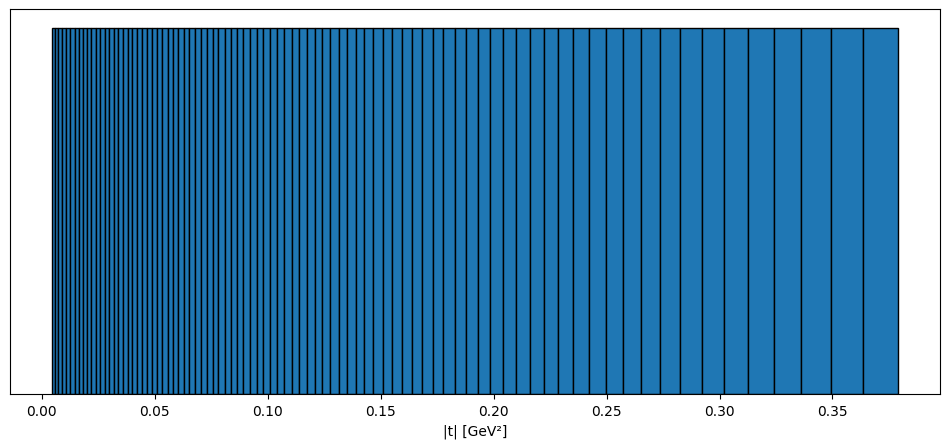

In [5]:
import matplotlib.pyplot as plt

bin_centers = 0.5 * (binning[:-1] + binning[1:])
bin_widths = np.diff(binning)

ratios = bin_widths[1:] / bin_widths[:-1]
average_ratio = np.mean(ratios)

print((f"Average Ratio (i+1 / i): {average_ratio:.3f}"))
plt.figure(figsize=(12, 5))
plt.bar(bin_centers, height=1, width=bin_widths, align='center', edgecolor='black')
plt.xlabel('|t| [GeV²]')
plt.yticks([])
plt.show()


**Figure 1.** Visual representation of binning

### Defining Angular Acceptance Thresholds

To enable precise acceptance corrections, we add dataset-specific constants (thresholds for $\theta_y^*$ and angular resolution $\sigma_{\theta_y}$) as new columns to the dataset. These include both the left and right RP thresholds, their effective averages, and the beam divergence. These constants are later used for computing the correction factor.


In [6]:
dataset_with_constants = dataset.Define("th_y_low_threshold_L", f"{diagonal_constants_rad['th_y_low_threshold_L']}")\
                                .Define("th_y_low_threshold_R", f"{diagonal_constants_rad['th_y_low_threshold_R']}")\
                                .Define("th_y_high_threshold_L", f"{diagonal_constants_rad['th_y_high_threshold_L']}")\
                                .Define("th_y_high_threshold_R", f"{diagonal_constants_rad['th_y_high_threshold_R']}")\
                                .Define("si_th_y", si_th_y_rad)\
                                .Define("th_y_low_threshold_eff", "(th_y_low_threshold_L + th_y_low_threshold_R) / 2.")\
                                .Define("th_y_high_threshold_eff", "(th_y_high_threshold_L + th_y_high_threshold_R) / 2.")

constants_columns = {"th_y_low_threshold_L", "th_y_low_threshold_R", "th_y_high_threshold_L", "th_y_high_threshold_R", "si_th_y", "th_y_low_threshold_eff", "th_y_high_threshold_eff"}

### Geometrical Correction

In elastic scattering experiments like TOTEM, protons scatter with small angles, and detectors measure these angles. However, not all scattering directions are equally visible due to **geometrical limitations**:

- The Roman Pot sensors can only detect protons that enter within a certain vertical range, typically bounded by the physical edges of the sensors (e.g., $\pm 20\, \mu\text{rad}$ -> inner edge of the detectors).
- The LHC machine aperture restricts protons with larger angles (e.g., $|\theta^*_y| \gtrsim 110\, \mu\text{rad}$ -> outer edge of the detectors), due to beam pipe or magnet obstructions.

As a result, we are not observing the full possible range of azimuthal directions at each scattering angle magnitude ($\theta^*$). This leads to an **artificial suppression of event counts**, especially at smaller scattering angles.

To correct for this incomplete coverage, we introduce the **geometrical correction factor** $A_{\text{geom}}$, defined as:

$$A_{\text{geom}} = \frac{\text{full arc length}}{\text{arc length within acceptance}} \tag{2}$$

This correction quantifies **what fraction of the full angular phase space is actually accepted by the detector system**. By multiplying event counts by $A_{\text{geom}}$, we compensate for the invisible regions and recover a more accurate estimate of the true differential distribution.


In the code below, for each event $A_{\text{geom}}$ is calculated as:

$$A_{\text{geom}} = \frac{\pi}{\phi_{\text{max}} - \phi_{\text{min}}}$$

* $\pi$ is the full range of azimuthal angle in one hemisphere (assuming symmetry).
* $\phi_{\text{min}}$ and $\phi_{\text{max}}$ define the visible slice in $\phi$ that falls within the detector's acceptance for that given scattering angle $\theta^*$.

From trigonometry: 

$$
\phi_{\min} = \arcsin\left( \frac{\theta_{y,\text{low}}}{\theta^*} \right)
$$

$$
\phi_{\max} =
\begin{cases}
\arcsin\left( \frac{\theta_{y,\text{high}}}{\theta^*} \right), & \text{if } \theta_{y,\text{high}} < \theta^* \\
\frac{\pi}{2}, & \text{otherwise}
\end{cases}
$$

Where:
$\theta_{y,\text{low}}$ and $\theta_{y,\text{high}}$ are the detector-specific thresholds for $\theta_y^*$ (adjusted by $\pm 0.5, \mu\text{rad}$ margin for stability).

In [7]:
dataset_Ageom = dataset_with_constants.Define("th_y_low_threshold", f"th_y_low_threshold_eff + 0.5E-6")\
                                                .Define("th_y_high_threshold", f"th_y_high_threshold_eff - 0.5E-6")\
                                                .Define("phi_min", f"asin(th_y_low_threshold / th)")\
                                                .Define("phi_max", f"th_y_high_threshold < th ? asin(th_y_high_threshold / th) : M_PI / 2")\
                                                .Define("A_geom", f"M_PI / (phi_max - phi_min)")

Ageom_helper_columns = {"th_y_low_threshold","th_y_high_threshold","phi_min","phi_max"}

### Fluctuations Correction

The reconstructed scattering angles are not exact—they are affected by statistical fluctuations, primarily due to two physical effects:
* Beam divergence: The beam itself has an intrinsic angular spread, meaning protons don’t all travel perfectly along the beam axis.
* Sensor resolution: Especially in the horizontal direction, finite detector precision introduces uncertainty in the measurement.

These fluctuations can cause protons that would ideally lie within the detector’s acceptance to appear as if they fall outside, or vice versa. This leads to systematic undercounting or overcounting of events near the acceptance boundaries.To account for this, the fluctuation correction factor $A_{\text{fluct}}$ is introduced. It is computed analytically by modeling the beam divergence as a Gaussian distribution with a known standard deviation.

The idea is to calculate the probability that one of the two protons in an elastic scattering is lost due to these fluctuations, even if the “real” scattering angle was within acceptance.

Mathematically:

The correction grows larger as you approach the edges of acceptance. To avoid unphysical large corrections, data points where $A_{\text{fluct}} > 3$ are discarded from the analysis. This approach ensures that the measured distributions are not biased by detector effects.

We compute the correction factor $A_{\text{fluct}}$ as the product of low-angle and high-angle corrections:
1. Low-angle correction:
This accounts for loss of events near the minimum angle thresholds.

$$\text{div\_corr}_l =
\begin{cases}
\displaystyle
\frac{2}{\mathrm{Erf}\left( \frac{|\theta_y| - \theta_{y,\text{low}}^L}{\sigma_{\theta_y}} \right)
-
\mathrm{Erf}\left( \frac{\theta_{y,\text{low}}^R - |\theta_y|}{\sigma_{\theta_y}} \right)},
& \text{if } |\theta_y| > \theta_{y,\text{low}}^{\text{eff}} \\
0, & \text{otherwise}
\end{cases}$$

2. High-angle correction:
This accounts for event loss near the maximum allowed angle.

$$\text{div\_corr}_h =
\begin{cases}
\displaystyle
\frac{2}{\mathrm{Erf}\left( \frac{\theta_{y,\text{high}}^L - |\theta_y|}{\sigma_{\theta_y}} \right)
-
\mathrm{Erf}\left( \frac{|\theta_y| - \theta_{y,\text{high}}^R}{\sigma_{\theta_y}} \right)},
& \text{if } |\theta_y| < \theta_{y,\text{high}}^{\text{eff}} \\
0, & \text{otherwise}
\end{cases}$$

3. Constraint:

This condition checks whether the scattering angle is within the geometrical acceptance window in both detectors (left and right).

* If **at least one** of them lies **outside** this window, the event is excluded from the analysis ($\text{div\_constraint} = 0$).
* If **both** are within the window, the event is considered **valid** ($\text{div\_constraint} = 1$).

Final formula:

$$A_{\text{fluct}} = \text{div\_corr}_l \cdot \text{div\_corr}_h \cdot \text{div\_constraint}$$


In [8]:
dataset_Ageom_Afluct = dataset_Ageom.Define("div_constraint", f"!(abs(th_y_L) < th_y_low_threshold_L || abs(th_y_R) < th_y_low_threshold_R || abs(th_y_L) > th_y_high_threshold_L || abs(th_y_R) > th_y_high_threshold_R)")\
                                        .Define("div_corr_l", f"(abs(th_y) > th_y_low_threshold_eff) ? 2. / (TMath::Erf((abs(th_y) - th_y_low_threshold_L) / si_th_y) - TMath::Erf((th_y_low_threshold_R - abs(th_y)) / si_th_y)) : 0")\
                                        .Define("div_corr_h", f"(abs(th_y) < th_y_high_threshold_eff) ? 2. / (TMath::Erf((th_y_high_threshold_L - abs(th_y)) / si_th_y) - TMath::Erf((abs(th_y) - th_y_high_threshold_R) / si_th_y)) : 0")\
                                        .Define("A_fluct", f"(div_corr_l * div_corr_h) * div_constraint")

Afluct_helper_columns = {"div_constraint", "div_corr_l", "div_corr_h"}

### Acceptance Correction
Calculating the full acceptance correction factor from the Eq. (1).

In [9]:
dataset_correction = dataset_Ageom_Afluct.Define("correction", "A_geom * A_fluct")

dataset_correction.Describe()

Dataframe from TChain TotemNtuple in file dataset3_after_cuts.root

Property                Value
--------                -----
Columns in total           72
Columns from defines       17
Event loops run             0
Processing slots           10

Column                  Type            Origin
------                  ----            ------
A_fluct                 double          Define
A_geom                  double          Define
bunch_num               UInt_t          Dataset
correction              double          Define
dataset_num             Int_t           Dataset
diagonal                Bool_t          Dataset
div_constraint          bool            Define
div_corr_h              double          Define
div_corr_l              double          Define
event_num               UInt_t          Dataset
input_status_bits       UInt_t          Dataset
phi_max                 double          Define
phi_min                 double          Define
run_no                  UInt_t          D

### Filtering out entries with invalid correction values

As noted earlier, the contribution from the divergence correction is significant only near the acceptance limits. However, it is limited to values below 3 by discarding data points that require larger corrections.

A correction value of 0 indicates that it could not be calculated, meaning the entry was outside the measurement limit due to a data error.

In [10]:
dataset_correction_filtered = dataset_correction.Filter("correction > 0", "Valid correction values, correction > 0")
dataset_correction_filtered = dataset_correction_filtered.Filter("A_fluct < 3", " A_fluct < 3")

dataset_correction_filtered.Report().Print()

Diagonal 45b56t: pass=43361      all=89819      -- eff=48.28 % cumulative eff=48.28 %
Valid correction values, correction > 0: pass=42793      all=43361      -- eff=98.69 % cumulative eff=47.64 %
 A_fluct < 3: pass=42645      all=42793      -- eff=99.65 % cumulative eff=47.48 %


## Graphical Representation of Correction Factors

In Figure 2, we observe how the correction factors used in the TOTEM analysis behave as a function of the four-momentum transfer squared, denoted by $|t|$. The geometrical correction factor exhibits a sharp change in shape at $|t| \approx 0.16\, \text{GeV}^2$, which is caused by the LHC aperture cuts.


### Geometrical and Divergence Correction Plots

In [11]:
profile_Ageom = dataset_correction_filtered.Profile1D((f"Dataset {dataset_number} Geometrical correction profile", f"Dataset {dataset_number}, diagonal {diagonal_number} Geometrical correction factor profile;|t| [GeV^2];A_{{geom}} [-]", len(binning)-1, binning), "t", "A_geom")
profile_Afluct = dataset_correction_filtered.Profile1D((f"Dataset {dataset_number} Divergence correction profile", f"Dataset {dataset_number}, diagonal {diagonal_number} Divergence correction factor profile;|t| [GeV^2];A_{{fluct}} [-]", len(binning)-1, binning), "t", "A_fluct")


corrections_canvas = ROOT.TCanvas("c11", "Phi_profile", 1000, 500)
corrections_canvas.Divide(2, 1)

corrections_canvas.cd(1)
profile_Ageom.SetStats(0)
profile_Ageom.Draw()
profile_Ageom.GetYaxis().SetRangeUser(2,8.5)

corrections_canvas.cd(2)
profile_Afluct.SetStats(0)
profile_Afluct.Draw()


corrections_canvas.Draw()

**Figure 2.** Correction factor profiles: $A_{geom}$ on the left and $A_{fluct}$ on the right.

**The plot on the left displays $A_{\text{geom}}(|t|)$, which quantifies the fraction of the phase space that is actually covered by the detector.**
* There is a sharp change in curvature at $|t| \approx 0.16\ , \text{GeV}^2$, which corresponds to the point where events start to be cut off by the LHC aperture, not just the sensor edges.
* At very low $|t|$, the correction is large because the acceptance is narrow — the detectors can't see protons scattered at extremely small angles.
As $|t|$ increases, more of the elastic phase space becomes visible, and $A_{\text{geom}}$ decreases, but after the aperture limit is reached, it increases again because high-angle protons are blocked.

**The graph on the right depicts $A_{\text{fluct}}(|t|)$, which accounts for how much the beam divergence and resolution smear the scattering angles, causing protons to “leak” out of the acceptance.**
* $A_{\text{fluct}}$ is close to 1 across most of the range. This means fluctuations are not very large and corrections are moderate.
* At the edges of acceptance, particularly near $|t| \approx 0.1$–$0.2\, \text{GeV}^2 $, we see small peaks due to the enhanced impact of beam divergence.
* The fluctuations are modeled as a Gaussian beam smearing, and this correction ensures events near acceptance limits are not over- or under-counted.



### Combined Correction Plot

In [12]:
profile_correction = dataset_correction_filtered.Profile1D((f"Dataset {dataset_number}, diagonal {diagonal_number} Correction profile", f"Dataset {dataset_number}, diagonal {diagonal_number} Acceptance correction factor profile;|t| [GeV^2];A [-]", len(binning)-1, binning), "t", "correction")

correction_canvas = ROOT.TCanvas("c13", "correction_profile")
profile_correction.Draw()
profile_correction.SetStats(0)
profile_correction.GetYaxis().SetRangeUser(2, 13)

correction_canvas.Draw()

**Figure 3.** Full acceptance correction factor profile- product of the two factors plotted in Fig. 2.


**Low $|t|$ Region ($|t| < 0.05\, \text{GeV}^2$):**
The correction factor is high and drops sharply as $|t|$ increases.
* At very small $|t|$, the corresponding scattering angle $\theta^*_y$ is also small. These small-angle protons pass very close to the beam, where the detector cannot reach due to safety constraints. Thus, only a small fraction of the full angular phase space is detected → a large correction is required to compensate.

**Middle Region ($0.05 < |t| < 0.15\, \text{GeV}^2$):**
The correction factor reaches a minimum (~2.3), where acceptance is best.
* In this region, most of the proton trajectories are well within the detector's acceptance. Both $A_{\text{geom}}$ and $A_{\text{fluct}}$ are small and stable. (most reliable for analysis.)

**High $|t|$ Region ($|t| > 0.15\, \text{GeV}^2$):**
Correction factor increases again, especially after $|t| \approx 0.16\, \text{GeV}^2$.
* This is where the LHC aperture limits affect acceptance—protons scattered at large angles may hit collimators or beam pipe boundaries.
Additionally, fluctuations in angle can push events outside the acceptance even if their average $\theta^*_y$ is within range.

## Reasonable Acceptance Correction Region

The analysis was limited to bins where the correction factor $A(|t|)$ does not exceed 7.5. This decision is motivated by the following considerations:

The acceptance correction factor $A(|t|)$ indicates how much the observed data must be scaled to reflect the true number of events. A high correction factor implies that:
* A large fraction of events is missed by the detector due to geometrical and divergence-related limitations.
* The resulting measurement at that $|t|$ is heavily reliant on extrapolation and is thus statistically and systematically less reliable.
For example:

$$A(|t|) = 7.5 \Rightarrow \text{Only } \frac{1}{7.5} \approx 13\% \text{ of the events are detected}$$

This means 87% of events in that bin are missing and must be inferred from assumptions and corrections.

So the threshold of 7.5 is a conservative upper bound that balances:
* Retaining enough data for statistical significance,
* Avoiding bins with excessive corrections. 

In [13]:
threshold = 7.5

low = 0
high = float("inf")

t_threshold = 0


# Go through histogram from left to right
for i in range(1, profile_correction.GetNbinsX() + 1):
    bin_value = profile_correction.GetBinContent(i)  
    # Find first bin that is below threshold but is not 0 and calculate t threshold to filter out
    if bin_value < threshold and bin_value != 0:
        bin_low_edge = profile_correction.GetBinLowEdge(i-1)
        bin_width = profile_correction.GetBinWidth(i-1)
        t_threshold = bin_low_edge + bin_width # bin right edge
        break

print("t threshold value:", t_threshold)


dataset_correction_valid = dataset_correction_filtered.Filter(f"t >= {t_threshold}", f"Region where correction <= 7.5 (t >= {t_threshold})")
dataset_correction_valid.Report().Print()

t threshold value: 0.0057
Diagonal 45b56t: pass=43361      all=89819      -- eff=48.28 % cumulative eff=48.28 %
Valid correction values, correction > 0: pass=42793      all=43361      -- eff=98.69 % cumulative eff=47.64 %
 A_fluct < 3: pass=42645      all=42793      -- eff=99.65 % cumulative eff=47.48 %
Region where correction <= 7.5 (t >= 0.0057): pass=42464      all=42645      -- eff=99.58 % cumulative eff=47.28 %


### Acceptance Correction Profile with Applied Threshold 

In [14]:
profile_correction = dataset_correction_valid.Profile1D((f"Dataset {dataset_number}, diagonal {diagonal_number} Acceptance correction profile", f"Dataset {dataset_number}, diagonal {diagonal_number} Acceptance correction profile;t [GeV^2];A [-]", len(binning)-1, binning), "t", "correction")

correction_canvas = ROOT.TCanvas("c13", "correction_profile")
profile_correction.Draw()
profile_correction.SetStats(0)
profile_correction.GetYaxis().SetRangeUser(2, 8)

correction_canvas.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c13


**Figure 4.**  Full acceptance correction factor profile with applied threshold for reasonable uncertainties. 
As you can see, the point with the value 7.97 was discarded after the application of the threshold.

## Saving Results

Results are saved without helper columns that were only used to calculate divergence and acceptance correction.

In [15]:
columns_to_save = set(dataset_correction.GetColumnNames()) - constants_columns - Ageom_helper_columns - Afluct_helper_columns 

dataset_output_path = Path(f"dataset{dataset_number}_diagonal{diagonal_number}_correction.root")
dataset_correction_valid.Snapshot("TotemNtuple", dataset_output_path.as_posix(), columns_to_save)

<cppyy.gbl.ROOT.RDF.RResultPtr<ROOT::RDF::RInterface<ROOT::Detail::RDF::RLoopManager,void> > object at 0x102b27b40>